# Natural Language Processing Yelp Reviews

In this NLP project I will be attempting to classify Yelp Reviews into 1 star or 5 star categories based off the text content in the reviews.

I will use the [Yelp Review Data Set from Kaggle](https://www.kaggle.com/c/yelp-recsys-2013).

Each observation in this dataset is a review of a particular business by a particular user.

The "stars" column is the number of stars (1 through 5) assigned by the reviewer to the business. (Higher stars is better.) In other words, it is the rating of the business by the person who wrote the review.

The "cool" column is the number of "cool" votes this review received from other Yelp users. 

All reviews start with 0 "cool" votes, and there is no limit to how many "cool" votes a review can receive. In other words, it is a rating of the review itself, not a rating of the business.

The "useful" and "funny" columns are similar to the "cool" column.

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## The Data

**Read the yelp.csv file and set it as a dataframe called yelp.**

In [2]:
yelp = pd.read_csv('yelp.csv')

In [3]:
yelp.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


** Check the head, info , and describe methods on yelp.**

In [4]:
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
business_id    10000 non-null object
date           10000 non-null object
review_id      10000 non-null object
stars          10000 non-null int64
text           10000 non-null object
type           10000 non-null object
user_id        10000 non-null object
cool           10000 non-null int64
useful         10000 non-null int64
funny          10000 non-null int64
dtypes: int64(4), object(6)
memory usage: 781.3+ KB


In [5]:
yelp.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


**Create a new column called "text length" which is the number of words in the text column.**

In [6]:
yelp['text length'] = yelp['text'].apply(len)

# Exploratory Data Analysis

**Lets use the seaborn library to create a grid of 5 histograms of text length based off of the star ratings.**

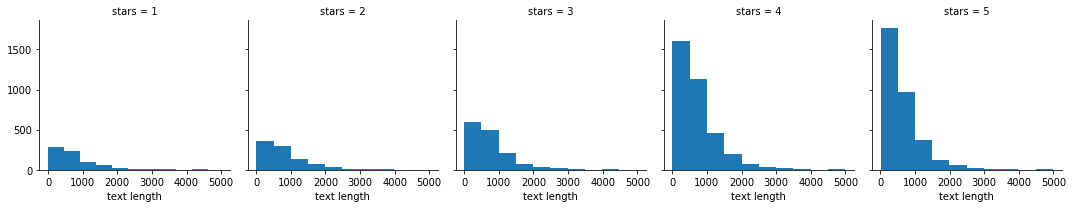

In [9]:
g = sns.FacetGrid(yelp, col='stars' )
g = g.map(plt.hist, 'text length')

**Now a boxplot of text length for each star category.**

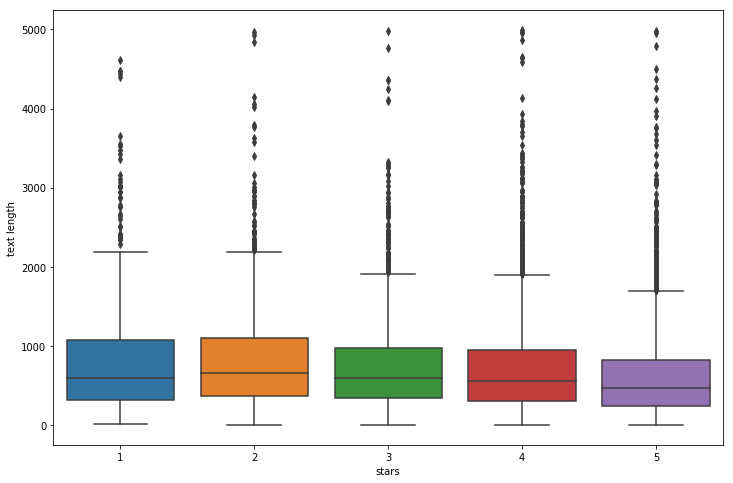

In [11]:
plt.figure(figsize=(12,8))
sns.boxplot(x = 'stars', y = 'text length', data = yelp);

**Lets examine a countplot of the number of occurrences for each type of star rating.**

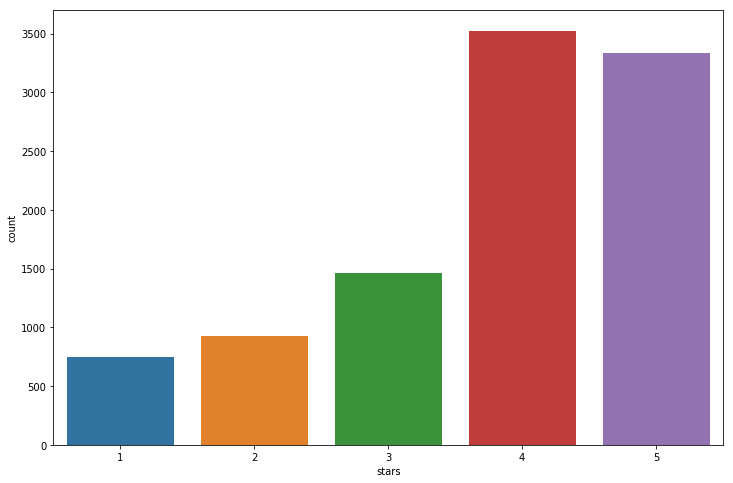

In [12]:
plt.figure(figsize=(12,8))
sns.countplot(x = 'stars', data = yelp);

** Next, lets take a look at the mean values of the numerical columns.**

In [13]:
stars = yelp.groupby('stars').mean()
stars

,cool,useful,funny,text length
stars,,,,
1,0.576769,1.604806,1.056075,826.515354
2,0.719525,1.563107,0.875944,842.256742
3,0.788501,1.306639,0.694730,758.498289
4,0.954623,1.395916,0.670448,712.923142
5,0.944261,1.381780,0.608631,624.999101


**Now the correlation**

In [22]:
stars.corr()

,cool,useful,funny,text length
cool,1.000000,-0.743329,-0.944939,-0.857664
useful,-0.743329,1.000000,0.894506,0.699881
funny,-0.944939,0.894506,1.000000,0.843461
text length,-0.857664,0.699881,0.843461,1.000000


**Lets examine the correlation further with a heatmap.**

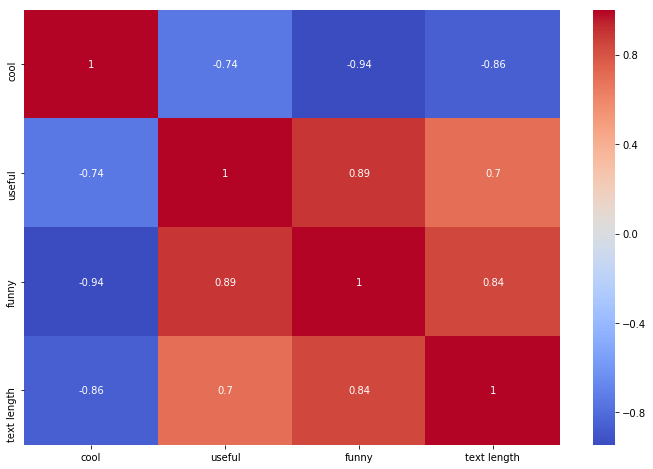

In [14]:
plt.figure(figsize=(12,8))
sns.heatmap(stars.corr(), cmap = 'coolwarm', annot = True);

## NLP Classification Task

For this exercise I will only examine reviews that were 1 or 5 stars.

**First I'll create a dataframe called yelp_class that contains the columns of yelp dataframe but for only the 1 or 5 star reviews.**

In [15]:
yelp_class = yelp[(yelp.stars == 1) | (yelp.stars ==5)]

** Create two objects X and y. X will be the 'text' column of yelp_class and y will be the 'stars' column of yelp_class. (The features and target/labels)**

In [16]:
X = yelp_class['text']
y = yelp_class['stars']

**Import CountVectorizer and create a CountVectorizer object.**

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

In [18]:
cv = CountVectorizer()

** Use the fit_transform method on the CountVectorizer object and pass in X (the 'text' column). Save this result by overwriting X.**

In [19]:
X = cv.fit_transform(X)

## Train Test Split

Let's split our data into training and testing data.

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)


## Training a Model

For our classification task, we will use the Naive Bayes Estimator. 

** Import MultinomialNB and create an instance of the estimator. **

In [24]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

**Now fit nb using the training data.**

In [25]:
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Predictions and Evaluations

Time to see how our model did!

In [26]:
predictions = nb.predict(X_test)

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

In [29]:
print('Confusion Matrix: \n',confusion_matrix(y_test, predictions))
print('\n')
print('Classification Report: \n', classification_report(y_test, predictions))

Confusion Matrix: 
 [[159  69]
 [ 22 976]]


Classification Report: 
              precision    recall  f1-score   support

          1       0.88      0.70      0.78       228
          5       0.93      0.98      0.96       998

avg / total       0.92      0.93      0.92      1226



**Great! Let's see what happens if we try to include TF-IDF to this process using a pipeline.**

# Using Text Processing

In [31]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

** Here is a pipeline with the following steps: CountVectorizer(), TfidfTransformer(),MultinomialNB()**

In [32]:
pipeline = Pipeline([
    ('count', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('nb', MultinomialNB())
])

## Using the Pipeline

### Train Test Split

**Redo the train test split on the yelp_class object.**

In [33]:
X = yelp_class['text']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)


**Now fit the pipeline to the training data. Remember you can't use the same training data as last time because that data has already been vectorized. We need to pass in just the text and labels**

In [34]:
pipeline.fit(yelp_class['text'], yelp_class['stars'])

Pipeline(memory=None,
     steps=[('count', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        stri...linear_tf=False, use_idf=True)), ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

### Predictions and Evaluation

** Now use the pipeline to predict from the X_test and create a classification report and confusion matrix.**

In [35]:
predictions2 = pipeline.predict(X_test)

In [36]:
print('Confusion Matrix: \n',confusion_matrix(y_test, predictions2))
print('\n')
print('Classification Report: \n',classification_report(y_test, predictions2))

Confusion Matrix: 
 [[  0 228]
 [  0 998]]


Classification Report: 
              precision    recall  f1-score   support

          1       0.00      0.00      0.00       228
          5       0.81      1.00      0.90       998

avg / total       0.66      0.81      0.73      1226



Looks like Tf-Idf actually made things worse! 